In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'


#######################Тут не все компании!!!######################################
#######################Тут не все компании!!!######################################
companies = ['SBER','GAZP' , 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'AFLT', 'AFKS',
       'TRNFP', 'CBOM',
       'FIVE', 'MOEX',
       'HYDR']
companies = ['SBER', 'SBERP', 'VTBR', 'TATNP','TRNFP', 'MOEX']
######################Тут не все компании!!!##############################################
######################Тут не все компании!!!##############################################

/tmp/ipykernel_15401/2117073850.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [3]:
# total_df.tradetime = total_df.close
# total_df.drop(['close', 'pr_close'], 1, inplace = True)
# total_df.rename(columns={'tradetime':'close'}, inplace=True)
# total_df = total_df.set_index('tradedate')

l = []
for i in companies:
    data = total_df[total_df['secid'] == i]
    l.append(data.shape[0])

max_len = min(l)
data = np.zeros((max_len, len(companies)))
for i, company in enumerate(companies):
    series = np.array(total_df[total_df.secid == company].close)[:max_len]
    data[:,i] += series

In [4]:

train_data = data[ : round(data.shape[0]*0.80) ]
val_data = data[ round(data.shape[0]*0.80) : ]


# train_data = data[ : round(data.shape[0]*0.55) ]
# val_data = data[ round(data.shape[0]*0.60) : ]

In [5]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [6]:
train_data1 = train_data[ : round(data.shape[0]*0.53) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [7]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [10]:
# lookback = 104
# horizon = 1

# x_train, y_train = sample_creator(data_train, lookback, horizon)
# x_val, y_val = sample_creator(data_val, lookback, horizon)

# print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')


lookback = 32
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5710, 32, 6]), y_train: torch.Size([5710, 1])
x_val: torch.Size([1550, 32, 6]), y_val: torch.Size([1550, 1])


In [11]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, fcst_horizon=1):
        '''
        LSTM с последующим дропаутом и двумя линейными слоями
        input_size: кол-во фичей(или совместно подаваемых рядов)
        hidden_size: внутренняя размерность каналов краткосрочной и долговсрочной памяти
        num_layers: количество LSTM слоёв
        dropout: коэффициент dropout
        fcst_horizon: длина горизонта прогнозировния
        '''
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.fcst_horizon = fcst_horizon
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(self.hidden_size, 32)
        self.fc2 = nn.Linear(32, self.fcst_horizon)

    def forward(self, x):
        x, _ = self.lstm(x) # Prediction и логи долгосрочной памяти( x.shape = (B, len_seq, hidden_size))
        x = self.dropout(x[:,-1,:])# Отбираем в B матрицах размера (len_seq,hidden_size) только последние вектора
        x = self.fc1(x) #Постепенно из 64 мерного пространства сводим в 1 мерное
        x = self.fc2(x) #Постепенно из 64 мерного пространства сводим в 1 мерное
        return x

In [12]:
model = LSTMModel(input_size=len(companies), hidden_size=512, num_layers=2, dropout=0.1, fcst_horizon=1).to(device)

In [25]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.00041:
        torch.save(model.state_dict(), f'ВЕСА/LSTM(M F=AS) 1D|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.074380 Validation Loss: 0.026730


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.003710 Validation Loss: 0.001171


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.001551 Validation Loss: 0.009875


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.001484 Validation Loss: 0.008168


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.001189 Validation Loss: 0.005430


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.5000e-03.
Epoch 6 / 50,Train Loss: 0.001166 Validation Loss: 0.003391


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.001023 Validation Loss: 0.004512


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.000950 Validation Loss: 0.002691


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.000913 Validation Loss: 0.001701


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 7.5000e-04.
Epoch 10 / 50,Train Loss: 0.000920 Validation Loss: 0.001490


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.000855 Validation Loss: 0.001452


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.000839 Validation Loss: 0.001565


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.000927 Validation Loss: 0.001713


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14 / 50,Train Loss: 0.000830 Validation Loss: 0.000981


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.000812 Validation Loss: 0.000871


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.000827 Validation Loss: 0.000841


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.000862 Validation Loss: 0.000716


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18 / 50,Train Loss: 0.000878 Validation Loss: 0.000477


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.000813 Validation Loss: 0.000320


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.000777 Validation Loss: 0.000703


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.000788 Validation Loss: 0.000765


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.000803 Validation Loss: 0.000845


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 3.7500e-04.
Epoch 23 / 50,Train Loss: 0.000886 Validation Loss: 0.000335


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.000745 Validation Loss: 0.000334


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.000725 Validation Loss: 0.000325


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26 / 50,Train Loss: 0.000750 Validation Loss: 0.000330


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.000762 Validation Loss: 0.000304


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.000744 Validation Loss: 0.000397


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 0.000727 Validation Loss: 0.000289


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30 / 50,Train Loss: 0.000729 Validation Loss: 0.000304


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.000752 Validation Loss: 0.000337


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.000710 Validation Loss: 0.000297


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 0.000721 Validation Loss: 0.000277


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34 / 50,Train Loss: 0.000691 Validation Loss: 0.000293


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.000686 Validation Loss: 0.000335


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.000741 Validation Loss: 0.000276


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 0.000687 Validation Loss: 0.000339


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 38 / 50,Train Loss: 0.000738 Validation Loss: 0.000270


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.000691 Validation Loss: 0.000278


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.000716 Validation Loss: 0.000303


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 0.000768 Validation Loss: 0.000305


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 1.8750e-04.
Epoch 42 / 50,Train Loss: 0.000674 Validation Loss: 0.000298


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43 / 50,Train Loss: 0.000675 Validation Loss: 0.000276


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44 / 50,Train Loss: 0.000701 Validation Loss: 0.000357


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45 / 50,Train Loss: 0.000710 Validation Loss: 0.000288


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 9.3750e-05.
Epoch 46 / 50,Train Loss: 0.000686 Validation Loss: 0.000295


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 47 / 50,Train Loss: 0.000623 Validation Loss: 0.000276


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48 / 50,Train Loss: 0.000668 Validation Loss: 0.000277


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49 / 50,Train Loss: 0.000651 Validation Loss: 0.000289


Train iter::   0%|          | 0/39 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00050: reducing learning rate of group 0 to 4.6875e-05.
Epoch 50 / 50,Train Loss: 0.000651 Validation Loss: 0.000282
Training complete in 0m 30s


In [49]:
# model = LSTMModel(input_size=34, hidden_size=512, num_layers=2, dropout=0.2, fcst_horizon=1).to(device)
# model.load_state_dict(torch.load('ВЕСА/LSTM(M F=AS) 1D|W=0.4862170928754841, VL=0.0002744422553397594'))

<All keys matched successfully>

In [26]:
# Evaluation
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)

In [28]:
winrate(y_val.reshape(-1,), predictions1)

0.49515816655907036

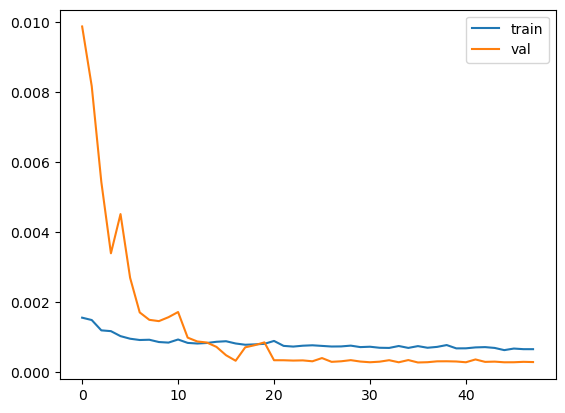

In [29]:
plt.plot(train_loss_per_epoch[2:])
plt.plot(val_loss_per_epoch[2:])
plt.legend(['train','val'])

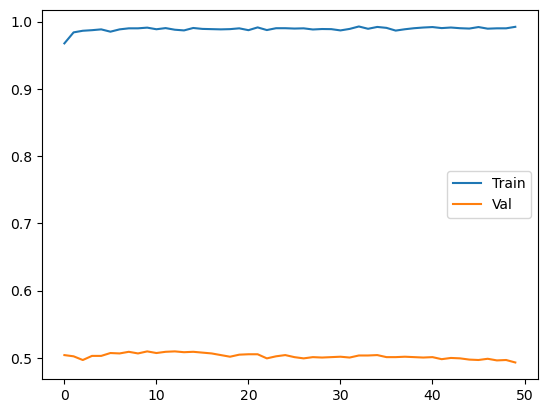

In [30]:
plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Train','Val'])

In [32]:
winrate(y_val.reshape(-1,), predictions1)

0.49515816655907036

In [36]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))
y_val = scaler_star.inverse_transform(y_val)

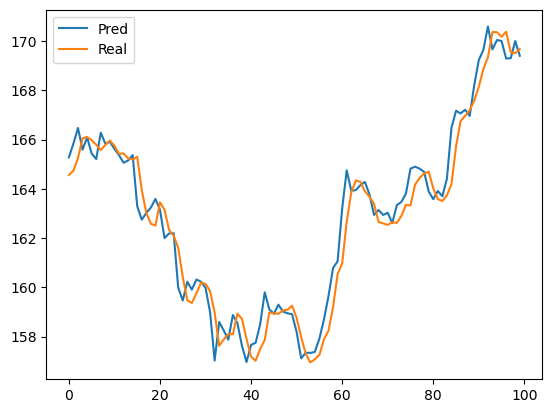

In [37]:
plt.plot(y_val[:100])
plt.plot(predictions1[:100])

plt.legend(['Pred','Real'])

In [38]:
criterion(torch.Tensor(predictions1), torch.Tensor(y_val))

tensor(1.5342)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [40]:
winrate(y_train.reshape(-1,), predictions2)

0.48940269749518306

In [41]:
y_train = scaler_star.inverse_transform(y_train)

In [42]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [43]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(2.1242)

In [45]:
torch.save(model.state_dict(), f'ЧВЕСА/[512,2,0.1]LSTM(M F=AS) 1D|W=0.4951, TL=2.1242 VL=2.5342' )

In [ ]:
[1024,3,0.1]LSTM(M F=TI) 1D|W=0.5906, TL=1.9928 VL=2.2113